In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con1 = sqlite3.connect('final.sqlite')
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews ", con1)


print(filtered_data.shape)
filtered_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# Data Cleaning: Deduplication

In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364171, 12)


100.0

In [4]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
12,138700,150518,0006641040,AK1L4EJBA23JF,L. M. Kraus,0,0,positive,1288224000,love this book,"Great book, perfect condition arrived in a sho...",great book perfect condit arriv short amount t...
13,138701,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,positive,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...,ive alway love chicken soup rice late ethel al...
14,138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,positive,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchas birthday gift year old boy squeal...
8,138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,positive,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....,great book ador illustr true classic kid love ...
34,476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
36,22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
35,22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
37,284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
142,157910,171225,7310172001,A314APAWYQFKBJ,"Diana Hersholt ""dog lover""",1,1,positive,1104796800,My dog loves these!,My dog is a very picky eater. She has a very ...,dog picki eater sensit stomach special food tr...
143,157909,171224,7310172001,AK0CENM3LUM28,Ana Mardoll,1,1,positive,1222732800,Pure Puppy Addiction,Pro-Treat Freeze Dried Liver Dog Treats / B000...,freez dri liver dog treat sort product make wi...


# Stemming, stop-word removal and Lemmatization

In [5]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [6]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [7]:
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
19,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children book ever written mini versi...
20,138709,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,june saw charm group rose begin droop pep chic...
21,138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,positive,1291075200,good for children,"Classic children's book, can't go wrong. I rea...",classic children book cant wrong read kid orde...
22,138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertain rhyme catchi illustr imagin fit righ...


In [8]:


# We will collect different 30K rows without repetition from time_sorted_data dataframe
my_final = final[:30000]
my_final.sort_values('Time',inplace=True) 

x = my_final['CleanedText'].values

# Implementing K-Means++ and K-medoids

# Bag of Words (BoW)

In [84]:
count_vect = CountVectorizer(min_df = 10) 
data = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text BOW vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (30000, 5322)
the number of unique words : 5322


# K-Means++ Implementation

In [10]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

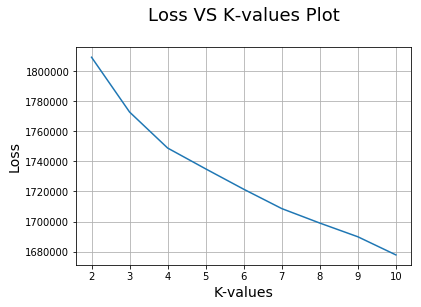

In [11]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4

In [12]:
optimal_k = 4
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

In [13]:
reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  3271

No. of reviews in Cluster-2 :  998

No. of reviews in Cluster-3 :  931

No. of reviews in Cluster-4 :  24800


READING REVIEWS MANUALLY

In [14]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 The wine saver is great in so many ways. Obviously it's wonderful to be able to open a bottle of wine and have it stay good for a day or two, especially if you just like one glass with dinner. This lets you open up and enjoy more expensive wine since you won't waste the whole rest of the bottle. If you are interested in learning about wines, you'll probably want to open up 2 or more wines at a time to compare them, and this way you won't waste anything. The wine saver will keep the undrunk portion until the next time.  I do recommend putting the bottle in the fridge if you don't drink it the next day. Just pull the bottle out an hour before you want to drink it if it's red.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has

In [15]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 I have two Burmese cats, and both of them are being or were raised on this kitten formula (one is 13 months, the other is 8 months).  They have been on it since they were 4 months old.  I did a lot of research into food recommended by my breeder since we spent a lot of money on the cats.  I ultimately decided on this brand because of the research they have done.  I plan on putting both of them on the Persian formula (that is for Himalayans and Burmese too) because these types of cats are prone to getting a certain type of UTI and need their urine a different pH.<br />Their fur has never been softer, they are so active and always chasing each other, they are very playful with us.  We always comment on how soft the older one is, just like a pillow, and the younger one is getting closer every day.  They eat the food I leave out for them every day, so I'm assuming it is satisfying.  I just love this brand and plan on sticking with them, even when we get dogs.

Review-2 : 
 I s

In [16]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 Blend a little apple cider mix into your Tazo Passion Tea and see what happens. This creates a magical apple cider experience with hints of cranberry and hibiscus flowers gathered in an ancient land.<br /><br />Snuggle Up Spiced Cider is a good choice because you can then spoon in the exact amount you desire, but packets of cider work equally well. This is the type of tea you would expect to enjoy after skiing in some distant forest where you are also munching on homemade brownies or eggnog cookies. Apple cider also works very well with the Gypsy Teas, especially the Lemon Jasmine.<br /><br />The deep purple/red color and hibiscus fragrance of Tazo Tea is enough to make anyone passionate about tea. Yet, is this really tea? It looks like tea, but it is really an herbal infusion made by steeping hibiscus flowers, orange peel, licorice, cinnamon, rose hips, lemongrass and red poppy in a swirling of hot water.<br /><br />The original flavor is also slightly reminiscent of hot 

In [17]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



# K-Medoids Implementation

In [85]:
def print_cluster_reviews_k_medoids(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(CLEANED_TEXT[review])
        print()
        index += 1

In [86]:
def get_cluster_N_medoids(k_medoids):
    return k_medoids.get_clusters(),k_medoids.get_medoids()

In [88]:
svd = TruncatedSVD(n_components=2)
bow_dtm_2_dim = svd.fit_transform(data)
bow_dtm_2_dim.shape

(30000, 2)

In [89]:
k_medoids = kmedoids.kmedoids(bow_dtm_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [90]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [91]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 25940 
Number of Reviews in Cluster 1 : 3116 
Number of Reviews in Cluster 2 : 944 


In [92]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
I mix this with sugar and sea salt, toss some potatoes in olive oil, and make great baked fries with this stuff. Such a unique flavor, and everyone in my house likes it- even the picky eaters. I love this stuff.

Review 2 : 
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review 3 : 
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books

# TFIDF

In [30]:
tf_idf_vect = TfidfVectorizer(min_df=10)
data = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text TFIDF vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (30000, 5322)
the number of unique words : 5322


In [32]:
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

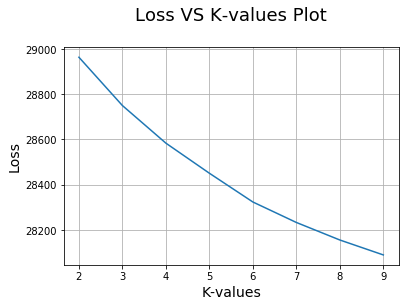

In [33]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

From above we can see that there is inflection at K = 6 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 6.

In [37]:
reviews = my_final['Text'].values
optimal_k = 6
# Variable that will be used in the conclusion 
tfidf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])    
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))


No. of reviews in Cluster-1 :  19844

No. of reviews in Cluster-2 :  1283

No. of reviews in Cluster-3 :  3252

No. of reviews in Cluster-4 :  1357

No. of reviews in Cluster-5 :  2706

No. of reviews in Cluster-6 :  1558


In [38]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



In [39]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 Chipotle makes everything taste better.  I first encountered this sauce at a small restaurant in New Mexico and it instantly made everything spicy and smoky.  We made sure to buy a few bottles in a Mexican grocery store, and I've used this on burgers, chicken, etc.  It's awesome.  And it's less than $2.  You can't beat that.

Review-2 : 
 I just love this sauce. I put in on everything.

Review-3 : 
 This sauce is excellent, and indeed spicy.  The brand also makes a mild version, in addition to other wonderful products like Rib Rub.  Made in North Carolina.  My husband doesn't like the sweeter type BBQ sauces - this brand he loves.



In [40]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I've bought a couple of these for my Airedale puppy who constantly wants to chew.  These things are amazing in that they have bone, tendon, meat, and knuckles still attached.  She dives in and tears it apart - she would work on it non-stop if I didn't periodically take it away from her.  The meat and tendons are harmless enough - obviously they have fat and protein so they have to be tied into diet considerations, and the bone appears to hold onto the flavor long after it's stripped (she still licks and gnaws on a bone that's a few weeks bare).  The knuckles, once they get torn off, should probably be thrown away after a few minutes because they are small enough to be swallowed and/or choked on.  The only downside to this product is when she comes up to me and the whiskers around her mouth are a little discolored and she smells like roasted meat.  But, well worth it if you want to give your dog a treat that they can't get enough of.

Review-2 : 
 I searched for a food that

In [41]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 Boots (the most handsome red tom cat you'll ever see!) loves these treats.  We keep them on a shelf in the pantry - only problem is everytime we open the pantry door he thinks he gets a treat.<p>  We've tried other cat treats which he always eats (truth is, Boots eats everything!) but these seem to be his favorite by far.

Review-2 : 
 My cat Foutchie is heading toward 5 now and no one told her the trouble with a kitten is it eventually becomes a cat (so take that Ogden Nash!).  She still voom-voom-vooms around at a pace that makes me exhausted.  She loves toys, especially stuff she chases.  So the bubbles are great full.  Especially since they are catnip bubbles.  You don't have the worry about them getting soap on them and making them sick.  She love jumping high to pop them.<p>So if you are looking for something to awaken the kitten in your kitty, you might try these.

Review-3 : 
 I have two Burmese cats, and both of them are being or were raised on this kitten formula

In [42]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1

Review-1 : 
 Blend a little apple cider mix into your Tazo Passion Tea and see what happens. This creates a magical apple cider experience with hints of cranberry and hibiscus flowers gathered in an ancient land.<br /><br />Snuggle Up Spiced Cider is a good choice because you can then spoon in the exact amount you desire, but packets of cider work equally well. This is the type of tea you would expect to enjoy after skiing in some distant forest where you are also munching on homemade brownies or eggnog cookies. Apple cider also works very well with the Gypsy Teas, especially the Lemon Jasmine.<br /><br />The deep purple/red color and hibiscus fragrance of Tazo Tea is enough to make anyone passionate about tea. Yet, is this really tea? It looks like tea, but it is really an herbal infusion made by steeping hibiscus flowers, orange peel, licorice, cinnamon, rose hips, lemongrass and red poppy in a swirling of hot water.<br /><br />The original flavor is also slightly reminiscent of hot 

In [43]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1

Review-1 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.

Review-2 : 
 After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck'

k-mediods

In [44]:
from sklearn.decomposition import TruncatedSVD
from pyclustering.utils import calculate_distance_matrix
from pyclustering.cluster import kmedoids

In [46]:
def print_cluster_reviews_k_medoids(cluster_label_reviews,cluster_number = 0,review_count=3):
    reviews = cluster_label_reviews[cluster_number]
    reviews = reviews[0:review_count]
    print("---: Cluster {0} :---".format(cluster_number))
    index = 1
    for review in reviews:
        print("Review {0} : ".format(index))
        print(CLEANED_TEXT[review])
        print()
        index += 1

In [47]:
def get_cluster_N_medoids(k_medoids):
    return k_medoids.get_clusters(),k_medoids.get_medoids()

In [48]:
svd = TruncatedSVD(n_components=2)
tfidf_dtm_2_dim = svd.fit_transform(data)
tfidf_dtm_2_dim.shape

(30000, 2)

In [49]:
k_medoids = kmedoids.kmedoids(tfidf_dtm_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [50]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [52]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 14235 
Number of Reviews in Cluster 1 : 3136 
Number of Reviews in Cluster 2 : 12629 


In [54]:
CLEANED_TEXT = my_final['Text'].values

In [55]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
I am not sure what they fed these guys but it is absolutely the best hare I ever eaten. I stuffed it with escargots and a creamy champagne cream sauce with truffles from Luxembourg and and eatable Thai Lilly flowers. Delightful. I added the leftovers to a Flan recipe that went over very well with the children. They all wanted more and skipped the ice cream. I'm ordering more. PS keep dental floss handy.

Review 2 : 
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review 3 : 
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thi

# Word2Vec

In [56]:
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  8130


In [57]:
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
data = train_vectors

# K-Means++ Implementation

In [58]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

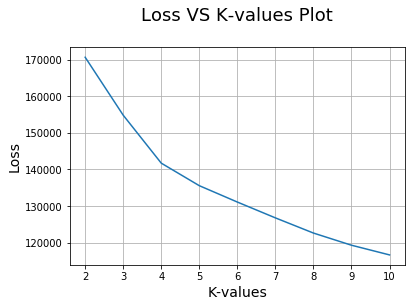

In [59]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

 From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4.

In [60]:
optimal_k = 4
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  4700

No. of reviews in Cluster-2 :  10441

No. of reviews in Cluster-3 :  6160

No. of reviews in Cluster-4 :  8699


In [61]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

In [62]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE COLLECTION. IT IS FILLED WITH COMEDY, ACTION, AND WHATEVER ELSE YOU WANT TO CALL IT.

Review-2 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-3 : 
 This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!



In [63]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.

Review-2 : 
 I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEATON AS BEETLEJUICE WAS RIGHT ON.  AND ALEC BALDWIN PLAYING A GEEKY HUSBAND IS PRICELESS.  I LOVE THE DA-OO SCENCE.  THE KIDS AND I REALLY ENJOY THIS ONE.

Review-3 : 
 It was on the other night, and, having been a big fan of the cartoon when it was being shown, decided to watch it (I'm also trying to see all the Winona Ryder movies I know.). <p> It's a well known fact i like seeing her [Winona Ryder] dance at the end of a movie (hey, it's funny!), but apart from that, it was just a hilarious film and i liked it very much. The only thing  wrong was that it was

In [64]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



# k-mediods

In [65]:
svd = TruncatedSVD(n_components=2)
avg_w2v_arr_2_dim = svd.fit_transform(data)
avg_w2v_arr_2_dim.shape

(30000, 2)

In [66]:
k_medoids = kmedoids.kmedoids(avg_w2v_arr_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [67]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [68]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 13243 
Number of Reviews in Cluster 1 : 10106 
Number of Reviews in Cluster 2 : 6651 


In [69]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
I toss this on most chicken items I make from whole chickens to wings.<br />Just to spice up things I put a little in prior to grilling and still keep whatever sauce I want.

Review 2 : 
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review 3 : 
I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The trad

# TFIDF-Word2Vec

In [70]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors

# K-Means++ Implementation

In [71]:


k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

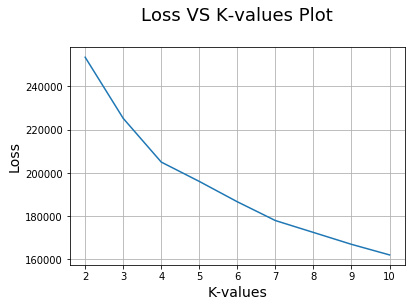

In [72]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

# From above we can see that there is inflection at K = 4 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 4

In [73]:
optimal_k = 4
# Variable that will be used in the conclusion 
tfidf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  3719

No. of reviews in Cluster-2 :  5283

No. of reviews in Cluster-3 :  10593

No. of reviews in Cluster-4 :  10405


In [74]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

In [75]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 Boots (the most handsome red tom cat you'll ever see!) loves these treats.  We keep them on a shelf in the pantry - only problem is everytime we open the pantry door he thinks he gets a treat.<p>  We've tried other cat treats which he always eats (truth is, Boots eats everything!) but these seem to be his favorite by far.

Review-2 : 
 My cat Foutchie is heading toward 5 now and no one told her the trouble with a kitten is it eventually becomes a cat (so take that Ogden Nash!).  She still voom-voom-vooms around at a pace that makes me exhausted.  She loves toys, especially stuff she chases.  So the bubbles are great full.  Especially since they are catnip bubbles.  You don't have the worry about them getting soap on them and making them sick.  She love jumping high to pop them.<p>So if you are looking for something to awaken the kitten in your kitty, you might try these.

Review-3 : 
 Are you supposed to avoid sugars if you have a urinary tract infection?



In [76]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



In [77]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 I'm getting crazy.I'm looking for Beatlejuice french version video.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks

Review-2 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-3 : 
 This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!



# k-mediods

In [79]:
svd = TruncatedSVD(n_components=2)
tfidf_w2v_arr_2_dim = svd.fit_transform(data)
tfidf_w2v_arr_2_dim.shape

(30000, 2)

In [80]:
k_medoids = kmedoids.kmedoids(tfidf_w2v_arr_2_dim,[2, 9, 12],0.001,ccore=True)
# Run cluster analysis and obtain results
k_medoids.process()

In [81]:
clusters,medoids = get_cluster_N_medoids(k_medoids)

In [82]:
for i in range(0,len(clusters)):
    list_if_indices = clusters[i]
    # Number of reviews in different clusters
    print("Number of Reviews in Cluster {0} : {1} ".format(i,len(list_if_indices)))

Number of Reviews in Cluster 0 : 5676 
Number of Reviews in Cluster 1 : 7068 
Number of Reviews in Cluster 2 : 17256 


In [83]:
print_cluster_reviews_k_medoids(clusters,cluster_number = 0, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 1, review_count = 3)
print("\n\n")
print_cluster_reviews_k_medoids(clusters,cluster_number = 2, review_count = 3)
print("\n\n")

---: Cluster 0 :---
Review 1 : 
My cat recently freaked out over some catnip that came with a bed I bought him so I thought I'd order some more.  I couldn't find the same brand but this "Xtreme" catnip sounded like it might do the trick.  Not even close.  My husband swears he saw our cat lift up his paw and yawn after smelling it.  If your cat is like mine you'll probably get a better reaction out of any other catnip out there.

Review 2 : 
I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.

Review 3 : 
I have just recently purchased the Woodstream Corp 0610 gopher trap, and  within 10 minutes of laying the traps i was catching  gophers. This product  is the best i have ever used.

# Conclusion

In [93]:
from prettytable import PrettyTable

names = ['K-means++ for BoW','K-medoids for BoW','K-means++ for TFIDF','K-medoids for TFIDF','K-means++ for Avg_Word2Vec',\
         'K-medoids for Avg_Word2Vec','K-means++ for tfidf_Word2Vec','K-medoids for tfidf_Word2Vec']

optimal_k = [4,3,6,3,4,3,4,3]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+------------------------------+---------------------+
| S.NO. |            MODEL             | Number of Clusters  |
+-------+------------------------------+---------------------+
|   1   |      K-means++ for BoW       |          4          |
|   2   |      K-medoids for BoW       |          3          |
|   3   |     K-means++ for TFIDF      |          6          |
|   4   |     K-medoids for TFIDF      |          3          |
|   5   |  K-means++ for Avg_Word2Vec  |          4          |
|   6   |  K-medoids for Avg_Word2Vec  |          3          |
|   7   | K-means++ for tfidf_Word2Vec |          4          |
|   8   | K-medoids for tfidf_Word2Vec |          3          |
+-------+------------------------------+---------------------+
